In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.stats import norm
from pandas_datareader import data as web
import math
import datetime

In [2]:
data = pd.read_excel("data_derivative.xlsx")
data.head()

,Date,Price
0,1990-01-02,37.750
1,1990-01-03,37.875
2,1990-01-04,38.125
3,1990-01-05,37.625
4,1990-01-08,37.250


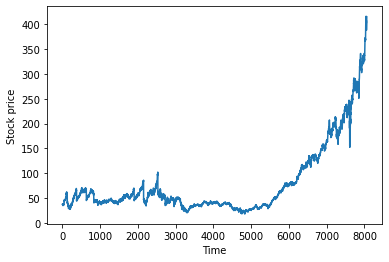

In [3]:
# draw a stock price line chart with x-axis as time
plt.plot(data['Price'])
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.show()

In [4]:
# rename the column name as 'HD'
data.rename(columns={'Price':'HD'}, inplace=True)


In [5]:
# Calculate the total return
total_return = (data['HD'].iloc[-1] - data['HD'].iloc[0]) / data['HD'].iloc[0]
print('Total return: {:.2f}%'.format(total_return))

Total return: 9.99%


In [6]:
# Calculate annualized return
annualized_return = (1 + total_return) ** (252 / len(data)) - 1
print('Annualized return: {:.2f}%'.format(annualized_return * 100))

Annualized return: 7.78%


In [7]:
# Calculate daily log return
data['log_return'] = np.log(data['HD'] / data['HD'].shift(1))
data.head()

,Date,HD,log_return
0,1990-01-02,37.750,NaN
1,1990-01-03,37.875,0.003306
2,1990-01-04,38.125,0.006579
3,1990-01-05,37.625,-0.013202
4,1990-01-08,37.250,-0.010017


/var/folders/bc/mkltfzvn16j7ysq8h609lfnw0000gn/T/ipykernel_91792/842996397.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['log_return'].dropna(), bins=100, color='green')


<AxesSubplot:xlabel='log_return', ylabel='Density'>

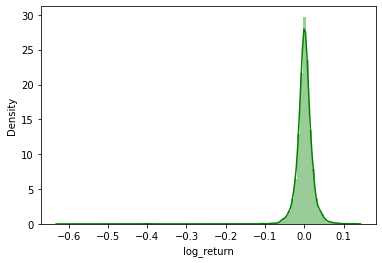

In [8]:
# draw the distribution of daily log return
sns.distplot(data['log_return'].dropna(), bins=100, color='green')

In [9]:
# Calculate the daily volatility of the stock
daily_volatility = data['log_return'].std()
print('Daily volatility: {:.2f}%'.format(daily_volatility*100))

Daily volatility: 2.33%


In [10]:
# Calculate the annualized volatility
annualized_volatility = daily_volatility * np.sqrt(252)
print('Annualized volatility: {:.2f}%'.format(annualized_volatility*100))

Annualized volatility: 36.96%


In [11]:
# Current stock price
current_price = data['HD'].iloc[-1]
print('Current price: ${:.2f}'.format(current_price))

Current price: $415.01


In [12]:
class MonteCarlo_Simulation():
    def __init__(self, spot: float, strike: float, volatility: float,
    r: float, maturity: float, scenarios: int, steps: int, option_type: str):
         self.spot = spot
         self.strike = strike
         self.volatility = volatility
         self.r = r
         self.maturity = maturity
         self.scenarios = scenarios
         self.steps = steps
         self.option_type = option_type

    def generate_scenario(self):
        dt = self.maturity / self.steps
        drift = (self.r - 0.5 * (self.volatility ** 2)) * dt
        variance_rate = self.volatility * np.sqrt(dt)

        noise = np.random.normal(loc= 0, scale=1, size= (self.steps, self.scenarios))
   
        paths = np.log(self.spot) + np.cumsum(drift + variance_rate * noise, axis=0) 

        return np.exp(paths)
    
    def visualize_scenarios(self,paths):
        fig = plt.figure(figsize=(12, 6))
        plt.plot(pd.DataFrame(paths))
        plt.xlabel('Time Steps')
        plt.ylabel('Stock price')
        plt.title('Simulated Stock Price Paths of '+str(self.scenarios) + ' Scenarios')
        plt.show()
    
    def payoff(self, paths):
        if self.option_type == 'call':
            return np.maximum(paths[-1] - self.strike, 0)
        elif self.option_type == 'put':
            return np.maximum(self.strike - paths[-1], 0)
        else:
            return 0
    
    def discount_expectation(self, payoff):
        return np.exp(-self.r * self.maturity) * np.mean(payoff)

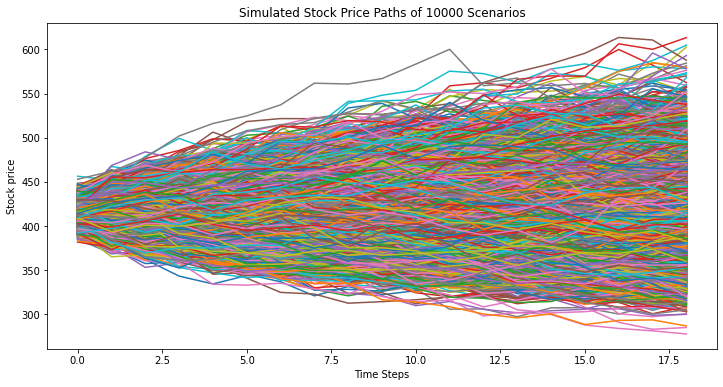

In [13]:
S = current_price
# not sure to use adj. close instead of close price (360.14)
K =  415.01 #360.14 ,366.98
T = 19 / 252
rf = 0.03
volatility_annum = annualized_volatility
steps = 19
n_path = 10000
Call_option = 'call'
Put_option = 'put'
pricer_call = MonteCarlo_Simulation(spot =S, strike = K, volatility = volatility_annum,
 r = rf, maturity= T, scenarios = n_path, steps = steps, option_type = Call_option)

paths_1 = pricer_call.generate_scenario()
pricer_call.visualize_scenarios(paths_1)
payoffs_call = pricer_call.payoff(paths_1)
expectation_call = pricer_call.discount_expectation(payoffs_call)

In [14]:
# Call Option Payofss for each scenario
payoffs_call

array([ 0.        ,  0.        , 20.27886151, ..., 52.80562476,
        0.        , 12.51532027])

In [15]:
# Calculate the call option payoffs at the end of the maturity
# The call option price can be calculated by the mean of the payoffs discounted by the risk-free rate
print('The call option price is: ${:.2f}'.format(expectation_call))

The call option price is: $17.49


In [16]:
# Compute the number of scenarios that the call option is in the money
print('The number of scenarios that the call option is in the money {:.2f}% of the time'.format(payoffs_call[payoffs_call > 0].shape[0] / n_path * 100))

The number of scenarios that the call option is in the money 48.20% of the time


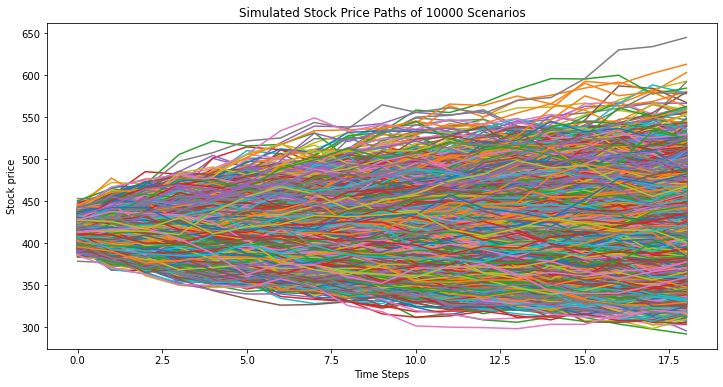

In [17]:
pricer_put = MonteCarlo_Simulation(spot =S, strike = K, volatility = volatility_annum,
    r = rf, maturity= T, scenarios = n_path, steps = steps, option_type = Put_option)

paths_2 = pricer_put.generate_scenario()
pricer_put.visualize_scenarios(paths_2)
payoffs_put = pricer_put.payoff(paths_2)
expectation_put = pricer_put.discount_expectation(payoffs_put)

In [18]:
# Put Option Payofss for each scenario
payoffs_put

array([ 0.        ,  7.45950856,  0.        , ...,  6.11105796,
       13.7158461 ,  0.        ])

In [19]:
# calculate the put option payoffs at the end of the maturity
# The put option price can be calculated by the mean of the payoffs discounted by the risk-free rate
print('The put option payoff is: ${:.2f}'.format(expectation_put))

The put option payoff is: $16.07


In [20]:
# Compute the number of scenarios that the put option is in the money
print('The put option is in the money {:.2f}% of the time'.format(payoffs_put[payoffs_put > 0].shape[0] / n_path * 100))

The put option is in the money 50.84% of the time


In [21]:
# Non-exercised put options are worthless
print('The number of non exercised put options: {:.2f}'.format(np.count_nonzero(payoffs_put)))

The number of non exercised put options: 5084.00


- REAL WORLD

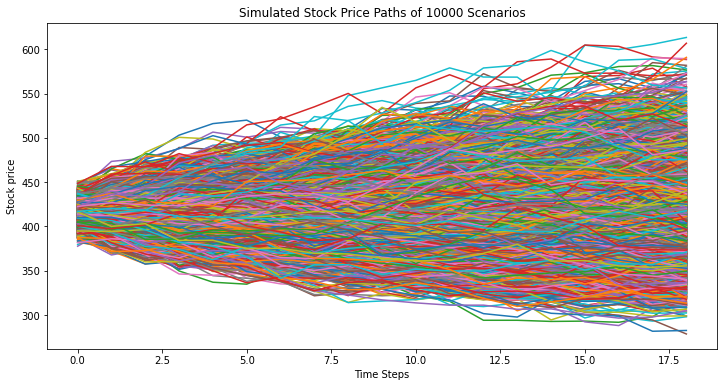

In [22]:
# Calculate the expected payoffs in the real world
log_return_mean = data['log_return'].mean()
expected_return = data['HD'].mean() / 100
expected_call_payoff = MonteCarlo_Simulation(spot =S, strike = K, volatility = volatility_annum,
 r = annualized_return, maturity= T, scenarios = n_path, steps = steps, option_type = Call_option)

paths_3 = expected_call_payoff.generate_scenario()
expected_call_payoff.visualize_scenarios(paths_3)
exp_payoffs_call = expected_call_payoff.payoff(paths_3)
real_expectation_call = expected_call_payoff.discount_expectation(exp_payoffs_call)

In [23]:
# Calculate the expected call option payoffs at the end of the maturity
print('The expected call option price is: ${:.2f}'.format(real_expectation_call))

The expected call option price is: $18.04


In [24]:
# Compute the number of scenarios that the expected call option is in the money
print('The number of scenarios that the expected call option is in the money {:.2f}% of the time'.format(exp_payoffs_call[exp_payoffs_call > 0].shape[0] / n_path * 100))

The number of scenarios that the expected call option is in the money 50.30% of the time


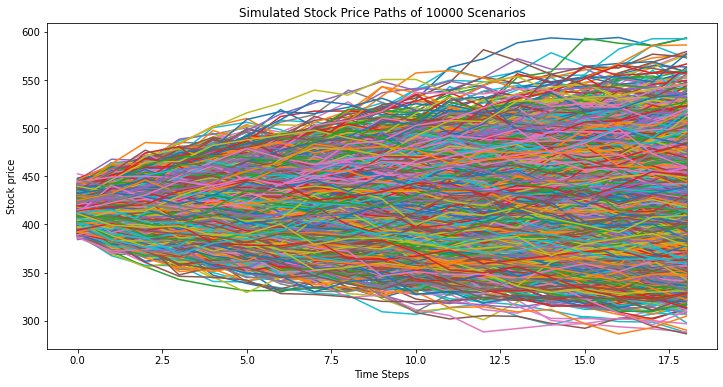

In [25]:
# Calculate the expected put option payoffs in the real world
expected_put_payoff = MonteCarlo_Simulation(spot =S, strike = K, volatility = volatility_annum,
    r = annualized_return, maturity= T, scenarios = n_path, steps = steps, option_type = Put_option)

paths_4 = expected_put_payoff.generate_scenario()
expected_put_payoff.visualize_scenarios(paths_4)
exp_payoffs_put = expected_put_payoff.payoff(paths_4)
real_expectation_put = expected_put_payoff.discount_expectation(exp_payoffs_put)

In [26]:
# Calculate the expected put option payoffs at the end of the maturity
print('The expected put option price is: ${:.2f}'.format(real_expectation_put))

The expected put option price is: $15.83


In [27]:
# Compute the number of scenarios that the expected put option is in the money
print('The number of scenarios that the expected put option is in the money {:.2f}% of the time'.format(exp_payoffs_put[exp_payoffs_put > 0].shape[0] / n_path * 100))

The number of scenarios that the expected put option is in the money 50.36% of the time


QUESTION 7

In [28]:
# FROM QUESTION 5
# CALL = 17.49
# PUT = 16.40
#FROM QUESTION 6
# CALL = 18.32
# PUT = 15.40

# Determine expected returns of both options
expected_Call = (17.49 / 18.32)-1
expected_Put = (16.40 / 15.40)-1
print('Expected return of Call option: {:.2f}%'.format(expected_Call * 100))
print('Expected return of Put option: {:.2f}%'.format(expected_Put * 100))

Expected return of Call option: -4.53%
Expected return of Put option: 6.49%


Black-Scholes-Merton Model

In [29]:
# Determine Black-Scholes call option price
rf = 0.03
d1 = (np.log(S / K) + (rf + 0.5 * (volatility_annum ** 2)) * T) / (volatility_annum * np.sqrt(T))
d2 = d1 - volatility_annum * np.sqrt(T)
call_option_price = S * norm.cdf(d1) - K * np.exp(-rf * T) * norm.cdf(d2)
print('The Black-Scholes call option price is: ${:.2f}'.format(call_option_price))

The Black-Scholes call option price is: $17.25


In [30]:
# Determine Black-Scholes put option price
put_option_price = K * np.exp(-rf * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
print('The Black-Scholes put option price is: ${:.2f}'.format(put_option_price))

The Black-Scholes put option price is: $16.31


Increase in Volatility

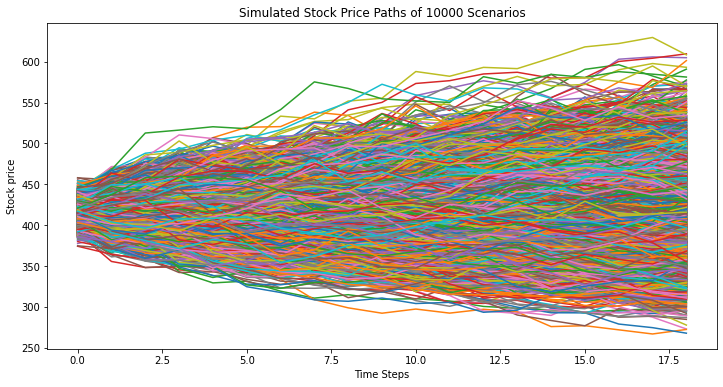

The call option price is: $18.43


In [31]:
# Increase the volatility by 10%
volatility_annum_2 = volatility_annum * 1.1

# Conduct new Monte Carlo simulation for the call option
pricer_call_2 = MonteCarlo_Simulation(spot =S, strike = K, volatility = volatility_annum_2,
    r = rf, maturity= T, scenarios = n_path, steps = steps, option_type = Call_option)

paths_5 = pricer_call_2.generate_scenario()
pricer_call_2.visualize_scenarios(paths_5)
payoffs_call_2 = pricer_call_2.payoff(paths_5)
expectation_call_2 = pricer_call_2.discount_expectation(payoffs_call_2)
print('The call option price is: ${:.2f}'.format(expectation_call_2))

In [32]:
# Compute the number of scenarios that the call option is in the money
print('The number of scenarios that the call option is in the money {:.2f}% of the time'.format(payoffs_call_2[payoffs_call_2 > 0].shape[0] / n_path * 100))

The number of scenarios that the call option is in the money 48.17% of the time


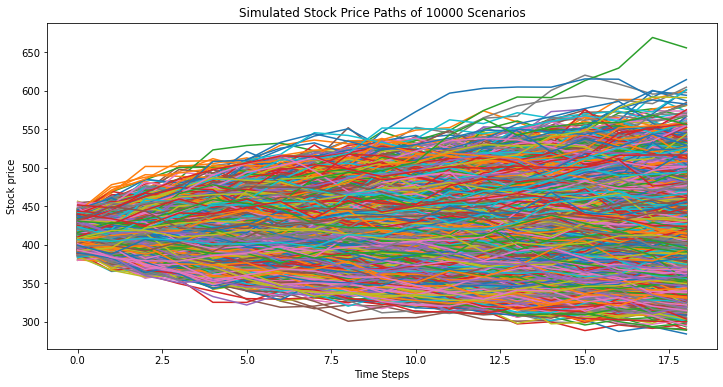

The put option price is: $17.63


In [33]:
# Conduct new Monte Carlo simulation for the put option
pricer_put_2 = MonteCarlo_Simulation(spot =S, strike = K, volatility = volatility_annum_2,
    r = rf, maturity= T, scenarios = n_path, steps = steps, option_type = Put_option)

paths_6 = pricer_put_2.generate_scenario()
pricer_put_2.visualize_scenarios(paths_6)
payoffs_put_2 = pricer_put_2.payoff(paths_6)
expectation_put_2 = pricer_put_2.discount_expectation(payoffs_put_2)
print('The put option price is: ${:.2f}'.format(expectation_put_2))

In [34]:
# Compute the number of scenarios that the put option is in the money
print('The number of scenarios that the put option is in the money {:.2f}% of the time'.format(payoffs_put_2[payoffs_put_2 > 0].shape[0] / n_path * 100))

The number of scenarios that the put option is in the money 51.01% of the time


In [35]:
# Calculate new Black-Scholes call option price with new volatility
d1_new = (np.log(S / K) + (rf + 0.5 * (volatility_annum_2 ** 2)) * T) / (volatility_annum_2 * np.sqrt(T))
d2_new = d1_new - volatility_annum_2 * np.sqrt(T)
call_option_price_new = S * norm.cdf(d1_new) - K * np.exp(-rf * T) * norm.cdf(d2_new)
print('The Black-Scholes call option price is: ${:.2f}'.format(call_option_price_new))

The Black-Scholes call option price is: $18.92


In [36]:
# Calculate new Black-Scholes put option price with new volatility
put_option_price_new = K * np.exp(-rf * T) * norm.cdf(-d2_new) - S * norm.cdf(-d1_new)
print('The Black-Scholes put option price is: ${:.2f}'.format(put_option_price_new))

The Black-Scholes put option price is: $17.99


The Greeks with Increasing Volatility

Only Vega will be change with an increase in volatility.
When stock price increases by an amount, the value of an option increases by Delta times that amount

In [37]:
# Delta call options with the change in volatility
print("The delta of call option with old volatility is: {:.2f}".format(norm.cdf(d1)))
print("The delta of call option with new volatility is: {:.2f}".format(norm.cdf(d1_new)))
print("The delta of put option with old volatility is: {:.2f}".format((norm.cdf(d1)-1)))
print("The delta of put option with new volatility is: {:.2f}".format((norm.cdf(d1_new)-1)))


The delta of call option with old volatility is: 0.53
The delta of call option with new volatility is: 0.53
The delta of put option with old volatility is: -0.47
The delta of put option with new volatility is: -0.47


In [38]:
# Gamma call options with the change in volatility
n_d1_derivative = 1/(np.sqrt(2*np.pi)) * np.exp(-d1**2/2)
gamma_call = n_d1_derivative / (S * volatility_annum * np.sqrt(T))
print("The gamma of call option with old volatility is: {:.2f}".format(gamma_call))

n_d1_derivative_new = 1/(np.sqrt(2*np.pi)) * np.exp(-d1_new**2/2)
gamma_call_new = n_d1_derivative_new / (S * volatility_annum_2 * np.sqrt(T))
print("The gamma of call option with new volatility is: {:.2f}".format(gamma_call_new))


The gamma of call option with old volatility is: 0.01
The gamma of call option with new volatility is: 0.01


In [39]:
# Gamma put options with the change in volatility
# gamma value does not change with volatility
gamma_put = n_d1_derivative  / (S * volatility_annum * np.sqrt(T))
print("The gamma of put option with old volatility is: {:.2f}".format(gamma_put))

gamma_put_new = n_d1_derivative_new / (S * volatility_annum_2 * np.sqrt(T))
print("The gamma of put option with new volatility is: {:.2f}".format(gamma_put_new))

The gamma of put option with old volatility is: 0.01
The gamma of put option with new volatility is: 0.01


In [40]:
# Vega call options with the change in volatility
vega_call = S * np.sqrt(T) * n_d1_derivative
print("The vega of call option is: {:.2f}".format(vega_call))

# when volatility increases by 10%, the option value increases by vega * 10%
print("The value of call and put options with 10% increase in volatility can increase by: {:.2f} %".format(vega_call * 0.1))


The vega of call option is: 45.34
The value of call and put options with 10% increase in volatility can increase by: 4.53 %


As the Vega formula to calculate call and put options are the same, the effect of changing volatility will be the same.